# Play with Mbs and Bandpasses

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy

TOAST INFO: mpi4py not found- using serial operations only


In [2]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tut01",
                     start_time=start_time,
                     duration_s=3600,
                     )

## One channel

In [3]:
#Initialize the channel
channel = lbs.FreqChannelInfo.from_imo(url='/releases/v1.3/satellite/MFT/M1-140/channel_info',imo=imo)

In [4]:
#Parameters of Mbs
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"],
    nside = 64,
    gaussian_smooth = True,
)

In [5]:
#Create the class and run the map generation
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
maps = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:05,962 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:06,053 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:06,054 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:06,056 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:06,291 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:06,297 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:06,298 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:06,299 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:06,460 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:06,466 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:06,467 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:06,468 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:09,208 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:09,209 INFO MPI#0000] -> fwhm is 30.800

In [6]:
maps.keys()

dict_keys(['M1-140', 'Coordinates', 'Mbs_parameters'])

In [7]:
#numpy array with the healpix map
maps['M1-140'].shape

(3, 49152)

In [8]:
#Coordinates of the simulated maps
maps['Coordinates']

<CoordinateSystem.Galactic: 2>

In [9]:
#Parameters of the Mbs simulations
maps['Mbs_parameters']

MbsParameters(nside=64, save=False, gaussian_smooth=True, bandpass_int=False, coadd=True, parallel_mc=False, make_noise=False, nmc_noise=1, seed_noise=None, n_split=False, make_cmb=False, cmb_ps_file='', cmb_r=0.0, nmc_cmb=1, seed_cmb=None, make_fg=True, fg_models={'pysm_synch_0': 'pysm_synch_0', 'pysm_freefree_1': 'pysm_freefree_1', 'pysm_dust_0': 'pysm_dust_0'}, make_dipole=False, sun_velocity=None, output_string='date_230628', units='K_CMB', maps_in_ecliptic=False)

## Many channels

In [10]:
#Obtain the info about the instrument from the imo
instrument = lbs.InstrumentInfo.from_imo(url="/releases/v1.3/satellite/MFT/instrument_info",imo=imo)

In [11]:
#Create a list with all the channels
channels=list()
for ch in instrument.channel_names:
    print(ch)
    channels.append(lbs.FreqChannelInfo.from_imo(url="/releases/v1.3/satellite/MFT/"+ch+"/channel_info",imo=imo))

M1-100
M2-119
M1-140
M2-166
M1-195


In [12]:
#Same as before but using the uuids
channels=list()
for uuid in instrument.channel_objs:
    channel = lbs.FreqChannelInfo.from_imo(url=uuid,imo=imo)
    print(channel.channel)
    channels.append(channel)

M1-100
M2-119
M1-140
M2-166
M1-195


In [13]:
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channels,
)
maps = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:15,356 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:15,363 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:15,365 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:15,367 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:15,641 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:15,648 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:15,649 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:15,650 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:15,897 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:15,902 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:15,903 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:15,904 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:16,121 INFO MPI#0000] Sigma is 16.052182 arcmin (0.004669 rad) 
[2023-06-28 15:06:16,122 INFO MPI#0000] -> fwhm is 37.800

In [14]:
for k in maps.keys():
    print(k)

M1-100
M2-119
M1-140
M2-166
M1-195
Coordinates
Mbs_parameters


## Some detectors

In [15]:
#Now we create a list of detectors 
channel = lbs.FreqChannelInfo.from_imo(url='/releases/v1.3/satellite/MFT/M1-140/channel_info',imo=imo)
wafer = 'M02'
orient = '45'
dets=[]
for uuid in channel.detector_objs:
    det = lbs.DetectorInfo.from_imo(url=uuid,imo=imo)
    if (det.wafer == wafer) and (det.orient == orient):
        dets.append(det)

In [16]:
#We run as before but with detector_list instead of channel_list
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:17,988 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:17,995 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:17,996 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:17,997 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:18,215 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:18,220 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:18,221 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:18,222 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:18,388 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:18,392 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:18,393 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:18,394 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:18,599 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:18,600 INFO MPI#0000] -> fwhm is 30.800

[2023-06-28 15:06:20,197 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:20,248 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:20,249 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:20,252 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:20,253 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:20,301 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:20,302 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:20,304 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:20,305 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:20,352 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:20,353 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:20,355 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:20,355 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:20,405 INFO MPI#0000]

[2023-06-28 15:06:22,213 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:22,214 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:22,260 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:22,261 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:22,263 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:22,264 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:22,309 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:22,310 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:22,312 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:22,313 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-06-28 15:06:22,362 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:22,363 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2023-06-28 15:06:22,367 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-06-28 15:06:22,368 

In [17]:
for k in maps.keys():
    print(k)

001_002_038_45B_140_B
001_002_041_45A_140_B
001_002_042_45B_140_B
001_002_047_45A_140_B
001_002_048_45B_140_B
001_002_052_45A_140_B
001_002_053_45B_140_B
001_002_056_45A_140_B
001_002_057_45B_140_B
001_002_060_45A_140_B
001_002_038_45B_140_T
001_002_041_45A_140_T
001_002_042_45B_140_T
001_002_047_45A_140_T
001_002_048_45B_140_T
001_002_052_45A_140_T
001_002_053_45B_140_T
001_002_056_45A_140_T
001_002_057_45B_140_T
001_002_060_45A_140_T
Coordinates
Mbs_parameters


## Now integrating over a top-hat bandpass

In [18]:
channel = lbs.FreqChannelInfo.from_imo(url='/releases/v1.3/satellite/MFT/M1-140/channel_info',imo=imo)

In [19]:
#We generate maps with an without band integration 
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"],
    nside = 64,
    gaussian_smooth = True,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsnoint = mbs.run_all()[0]

params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"],
    nside = 64,
    gaussian_smooth = True,
    bandpass_int = True
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel,
)
mapsint = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:22,953 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:22,959 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:22,961 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:22,961 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:23,158 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:23,163 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:23,164 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:23,164 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:23,331 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:23,335 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:23,336 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:23,337 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:23,545 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2023-06-28 15:06:23,546 INFO MPI#0000] -> fwhm is 30.800

generating and saving fg simulations


[2023-06-28 15:06:24,503 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:24,508 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:24,509 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:24,511 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:24,739 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:24,744 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:24,745 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:24,746 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:24,930 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:24,934 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:24,935 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:24,936 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:25,155 INFO MPI#0000] Removing 42/128 points below 1e-10
[2023-06-28 15:06:25,160 INFO MPI#0000] Removing 42/128 points b

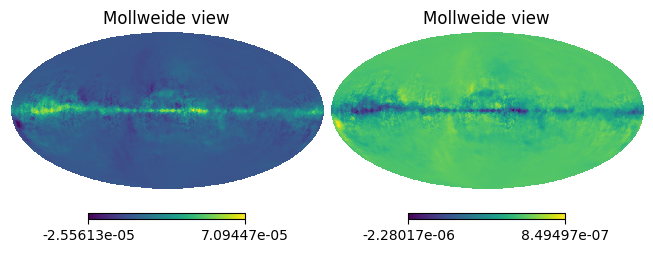

In [20]:
hp.mollview(mapsint['M1-140'][1],sub=121)
hp.mollview((mapsnoint['M1-140'] - mapsint['M1-140'])[1],sub=122)

## Now with a customized bandpass

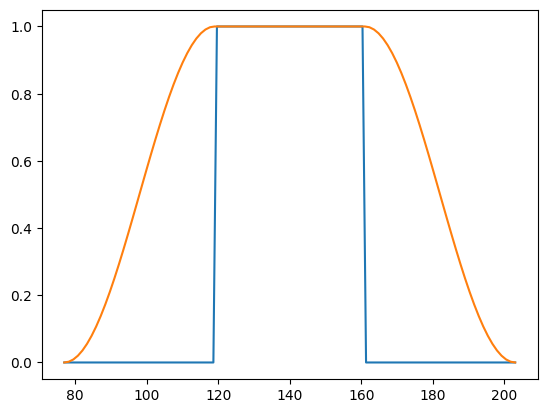

In [21]:
#We change the shape of the bands, in channel1 top-hat in channel2 top-hat with cosine tails

channel1 = lbs.FreqChannelInfo.from_imo(url='/releases/v1.3/satellite/MFT/M1-140/channel_info',imo=imo)

band = lbs.BandPassInfo(
    bandcenter_ghz=channel1.bandcenter_ghz,
    bandwidth_ghz=channel1.bandwidth_ghz,
    bandtype="top-hat-cosine",
    nsamples_inband=100,
)
channel2 = lbs.FreqChannelInfo.from_imo(url='/releases/v1.3/satellite/MFT/M1-140/channel_info',imo=imo)
channel2.band = band

plt.plot(channel1.band.freqs_ghz, channel1.band.weights, label="Ideal band")
plt.plot(channel2.band.freqs_ghz, channel2.band.weights, label="Ideal band")

In [22]:
#Here we do the comparison
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"],
    nside = 64,
    gaussian_smooth = True,
    bandpass_int = True
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel1,
)
mapsth = mbs.run_all()[0]

mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    channel_list=channel2,
)
mapsthc = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:27,211 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:27,218 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:27,220 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:27,221 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:27,447 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:27,451 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:27,452 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:27,453 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:27,621 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:27,626 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:27,627 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:27,628 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:27,857 INFO MPI#0000] Removing 42/128 points below 1e-10
[2023-06-28 15:06:27,864 INFO MPI#0000] Removing 42/128 points b

generating and saving fg simulations


[2023-06-28 15:06:29,134 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:29,139 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:29,140 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:29,140 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:29,368 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:29,372 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:29,373 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:29,374 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:29,530 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:29,534 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:29,535 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:29,536 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:29,737 INFO MPI#0000] Removing 98/100 points below 1e-10
[2023-06-28 15:06:29,742 INFO MPI#0000] Removing 98/100 points b

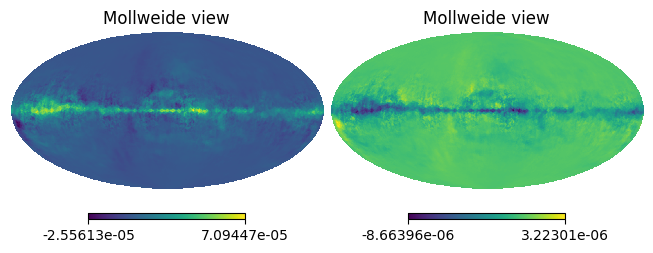

In [23]:
hp.mollview(mapsth['M1-140'][1],sub=121)
hp.mollview((mapsth['M1-140'] - mapsthc['M1-140'])[1],sub=122)

## Scan the sky

In [24]:
#Now we do a simple simulation of 1 hour with 4 detectors
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_002_060_45A_140_T",
    "001_003_000_75A_140_B",
    "001_003_001_15B_140_T",
    "001_003_002_60A_140_B",
]

In [25]:
start_time = 0.0
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tut01",
                     start_time=start_time,
                     duration_s=3600,
                     )

Can't resample if no sampler is built and/or provided, interpolating the band


/Users/luca/opt/anaconda3/envs/litebird_sim/lib/python3.9/site-packages/litebird_sim/bandpasses.py:246: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]
/Users/luca/opt/anaconda3/envs/litebird_sim/lib/python3.9/site-packages/litebird_sim/bandpasses.py:246: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(b, a=self.freqs_ghz.min(), b=inu)[0]


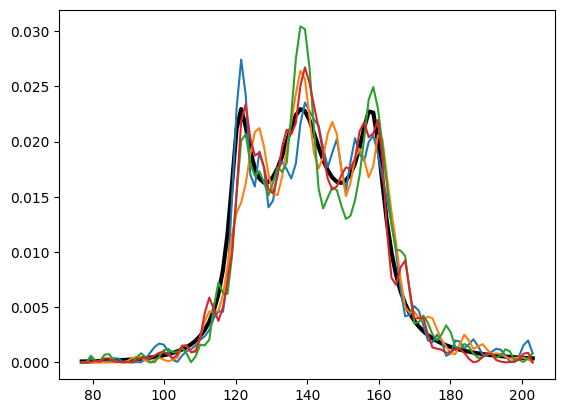

In [26]:
# Load the definition of the instrument (LFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/v1.3/satellite/{telescope}/instrument_info",
    )
)

channelinfo = lbs.FreqChannelInfo.from_imo(imo,f"/releases/v1.3/satellite/{telescope}/{channel}/channel_info")

band = lbs.BandPassInfo(
    bandcenter_ghz=channelinfo.bandcenter_ghz,
    bandwidth_ghz=channelinfo.bandwidth_ghz,
    bandtype="cheby",
    nsamples_inband=100,
    normalize=True
)

plt.plot(band.freqs_ghz,band.weights,lw=3,color='k')

dets = []
for namedet in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/v1.3/satellite/{telescope}/{channel}/{namedet}/detector_info",
        imo=imo,
    )
    det.quat = [0.,0.,0.,1.]
    det.band = band 
    det.fwhm_arcmin *= np.random.normal(1.,0.01)
    det.band.weights = band.bandpass_resampling()
    dets.append(det)
    plt.plot(band.freqs_ghz,det.band.weights)

In [27]:
sim.set_scanning_strategy(
    imo_url=f"/releases/v1.3/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

In [28]:
params = lbs.MbsParameters(
    make_cmb=False,
    make_fg=True,
    fg_models=["pysm_synch_0", "pysm_freefree_1","pysm_dust_0"],
    nside = 64,
    gaussian_smooth = True,
    bandpass_int = True
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=params,
    detector_list=dets,
)
maps = mbs.run_all()[0]

generating and saving fg simulations


[2023-06-28 15:06:37,896 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-06-28 15:06:37,903 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:37,905 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:37,907 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:38,297 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-06-28 15:06:38,305 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:38,306 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:38,308 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:38,534 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2023-06-28 15:06:38,542 INFO MPI#0000] NSIDE = 512
[2023-06-28 15:06:38,544 INFO MPI#0000] ORDERING = RING in fits file
[2023-06-28 15:06:38,546 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-06-28 15:06:38,828 INFO MPI#0000] Removing 97/100 points below 1e-10
[2023-06-28 15:06:38,835 INFO MPI#0000] Removing 97/100 points b

In [29]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ), 
)
sim.compute_pointings()

In [30]:
sim.fill_tods(maps)

Text(0, 0.5, 'Signal [K]')

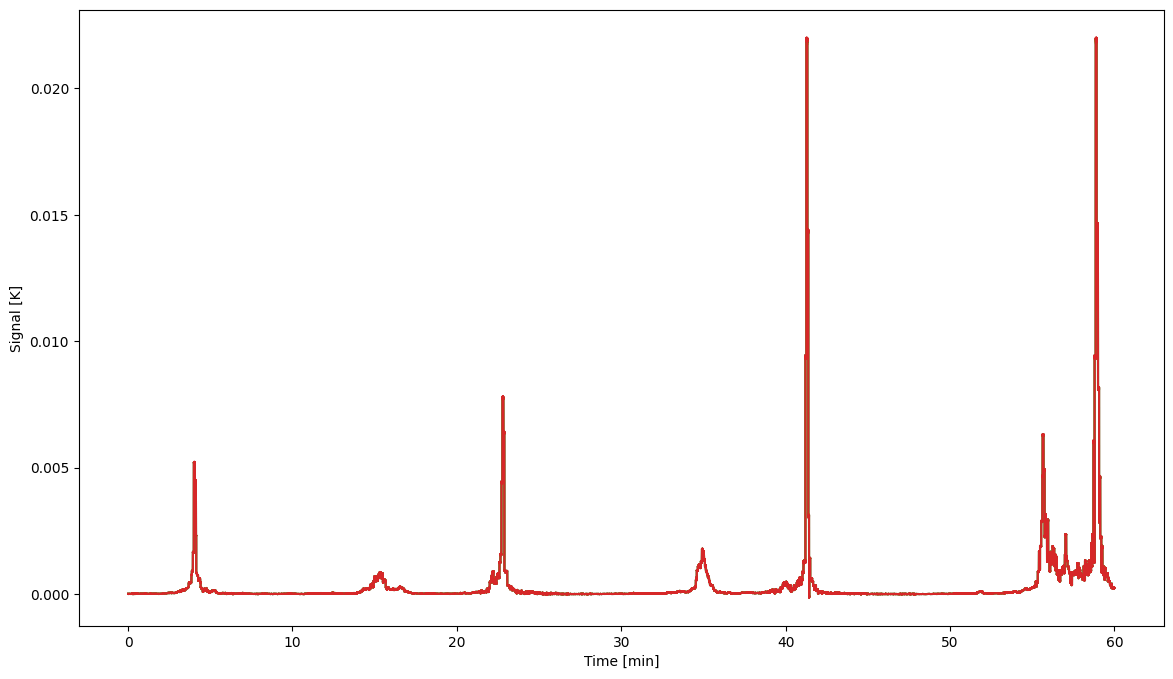

In [31]:
times_min = (
    sim.observations[0].get_times() - sim.observations[0].start_time
) / 60.0
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1])
plt.plot(times_min, sim.observations[0].tod[2])
plt.plot(times_min, sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

Text(0, 0.5, '$\\Delta$ Signal [K]')

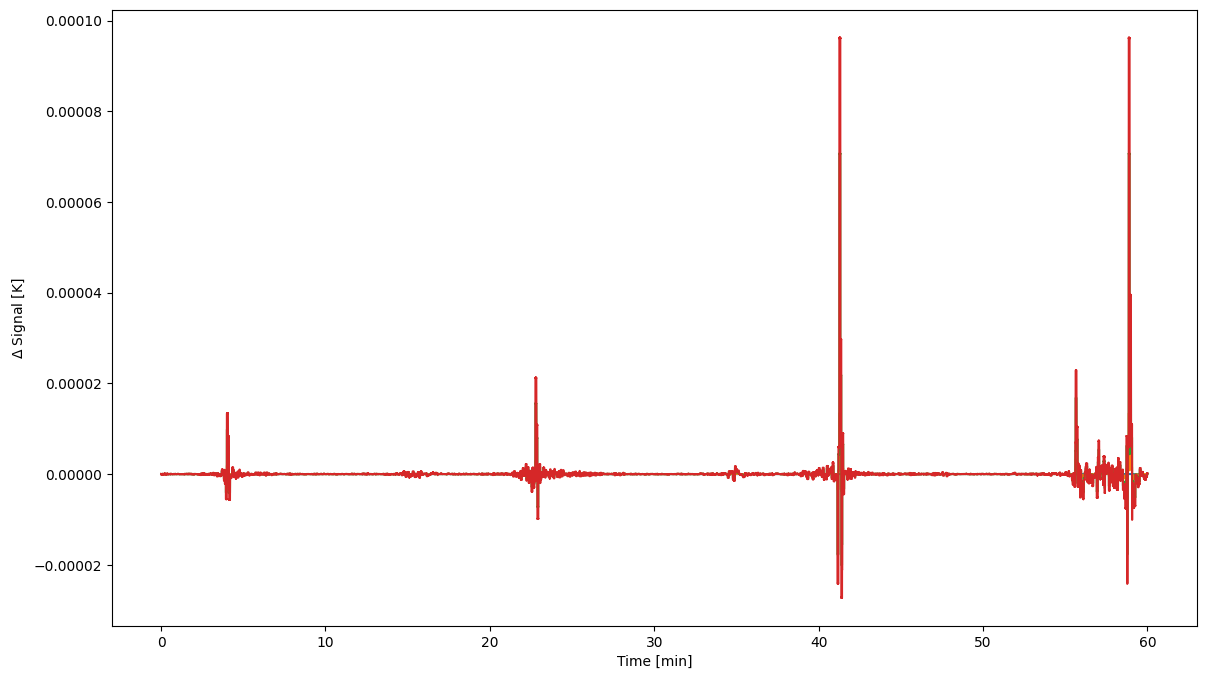

In [32]:
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0]-sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1]-sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[2]-sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[3]-sim.observations[0].tod[0])

plt.xlabel("Time [min]")
plt.ylabel(r"$\Delta$ Signal [K]")